In [12]:
# https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
import os
import ast
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
ROOT_DIR = "/workspace/resnet/"
ROOT_DATA_DIR = "/workspace/resnet/data/raw"
ARCHIVE_DIR = os.path.join(ROOT_DATA_DIR, "archive.zip")
DATA_DIR = os.path.join(ROOT_DATA_DIR)#, "labelme-12-50k")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_ANNOT_PATH = os.path.join(TRAIN_DIR, "annotation.txt")
TEST_DIR = os.path.join(DATA_DIR, "test")
TEST_ANNOT_PATH = os.path.join(TEST_DIR, "annotation.txt")
CLASSES_TXT_PATH = os.path.join(DATA_DIR, "classes.txt")
INTERIM_DATA_DIR = "/workspace/resnet/data/interim/"
# import zipfile
# with zipfile.ZipFile(ARCHIVE_DIR, 'r') as zip_ref:
#     zip_ref.extractall(ROOT_DATA_DIR)

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

with open(CLASSES_TXT_PATH) as file:
    class_map_s2i = {line.rstrip():i for i, line in enumerate(file.readlines()) if line.rstrip()}
class_map_i2s = {v:k for k,v in class_map_s2i.items()}
with open(TRAIN_ANNOT_PATH) as file:
    train_annots = [line.rstrip().split() for line in file.readlines()]
# train_img_path = [os.path.join(TRAIN_DIR, train_annot[0][:4], train_annot[0]+".jpg") for train_annot in train_annots]
train_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in train_annot[1:]])) for train_annot in train_annots]
train_str_lbl = [class_map_i2s[x] for x in train_int_lbl]
train_img_path = list()
for sub in range(0,40):
    sub_folder = f"{sub}".zfill(4)
    for file in range(0,1000):
        train_img_path.append(os.path.join(TRAIN_DIR, sub_folder, f"{sub_folder[-3:]}{str(file).zfill(3)}.jpg"))


In [14]:


with open(TEST_ANNOT_PATH) as file:
    test_annots = [line.rstrip().split() for line in file.readlines()]
test_img_path = [os.path.join(TEST_DIR, test_annot[0][:4], test_annot[0]+".jpg") for test_annot in test_annots]
test_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in test_annot[1:]])) for test_annot in test_annots]
test_str_lbl = [class_map_i2s[x] for x in test_int_lbl]
test_img_path = list()
for sub in range(0,10):
    sub_folder = f"{sub}".zfill(4)
    for file in range(0,1000):
        test_img_path.append(os.path.join(TEST_DIR, sub_folder, f"{sub_folder[-3:]}{str(file).zfill(3)}.jpg"))
        
train_df = pd.DataFrame({"img_path":train_img_path, "int_label":train_int_lbl, "str_label":train_str_lbl})
test_df = pd.DataFrame({"img_path":test_img_path, "int_label":test_int_lbl, "str_label":test_str_lbl})

print("\n\nTRAIN DF")
display(train_df)
print(train_df.str_label.value_counts(dropna=False))

print("\n\n\nTEST DF")
display(test_df)
print(test_df.str_label.value_counts())



TRAIN DF


,img_path,int_label,str_label
0,/workspace/resnet/data/raw/train/0000/000000.jpg,4,tree
1,/workspace/resnet/data/raw/train/0000/000001.jpg,1,car
2,/workspace/resnet/data/raw/train/0000/000002.jpg,2,building
3,/workspace/resnet/data/raw/train/0000/000003.jpg,1,car
4,/workspace/resnet/data/raw/train/0000/000004.jpg,1,car
...,...,...,...
39995,/workspace/resnet/data/raw/train/0039/039995.jpg,0,person
39996,/workspace/resnet/data/raw/train/0039/039996.jpg,0,person
39997,/workspace/resnet/data/raw/train/0039/039997.jpg,0,person
39998,/workspace/resnet/data/raw/train/0039/039998.jpg,0,person


person       24024
window        4153
car           3994
building      2233
tree          2073
sign           968
door           881
chair          432
bookshelf      404
keyboard       350
head           268
table          220
Name: str_label, dtype: int64



TEST DF


,img_path,int_label,str_label
0,/workspace/resnet/data/raw/test/0000/000000.jpg,1,car
1,/workspace/resnet/data/raw/test/0000/000001.jpg,0,person
2,/workspace/resnet/data/raw/test/0000/000002.jpg,1,car
3,/workspace/resnet/data/raw/test/0000/000003.jpg,1,car
4,/workspace/resnet/data/raw/test/0000/000004.jpg,0,person
...,...,...,...
9995,/workspace/resnet/data/raw/test/0009/009995.jpg,0,person
9996,/workspace/resnet/data/raw/test/0009/009996.jpg,1,car
9997,/workspace/resnet/data/raw/test/0009/009997.jpg,2,building
9998,/workspace/resnet/data/raw/test/0009/009998.jpg,0,person


person       5937
window       1043
car          1019
building      588
tree          543
sign          258
door          191
chair         107
bookshelf     103
keyboard       84
head           65
table          62
Name: str_label, dtype: int64


In [15]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=1)
train_df_balanced, balanced_labels = ros.fit_resample(train_df, train_df['int_label'])
train_df_balanced.str_label.value_counts()

tree         24024
car          24024
building     24024
person       24024
window       24024
sign         24024
door         24024
bookshelf    24024
chair        24024
keyboard     24024
head         24024
table        24024
Name: str_label, dtype: int64

In [16]:
train_df.shape

(40000, 3)

In [17]:
train_df_balanced.shape

(288288, 3)

In [18]:
# train_df_balanced_20000 = train_df_balanced_20000.sample(n=int(len(train_df)/2),random_state = 10)
train_df_balanced_20000 = train_df_balanced.sample(n=20000,random_state = 10)
train_df_balanced_40000 = train_df_balanced.sample(n=40000,random_state = 10)
train_df_balanced_20000.str_label.value_counts()

person       1752
table        1710
chair        1693
tree         1681
car          1668
building     1662
door         1655
window       1655
head         1647
bookshelf    1639
sign         1630
keyboard     1608
Name: str_label, dtype: int64

In [19]:
train_df_balanced_40000.str_label.value_counts()

person       3438
table        3422
bookshelf    3392
door         3325
head         3317
keyboard     3312
chair        3305
car          3303
building     3302
tree         3297
sign         3295
window       3292
Name: str_label, dtype: int64

In [20]:
train_df_balanced_40000.to_csv(os.path.join(INTERIM_DATA_DIR,"balanced-train-40000.csv"))
train_df_balanced_20000.to_csv(os.path.join(INTERIM_DATA_DIR,"balanced-train-20000.csv"))
train_df.to_csv(os.path.join(INTERIM_DATA_DIR,"train-40000.csv"))
test_df.to_csv(os.path.join(INTERIM_DATA_DIR,"test-10000.csv"))

keyboard /workspace/resnet/data/raw/train/0013/013218.jpg


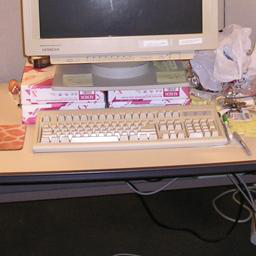

In [21]:
temp = train_df_balanced[train_df_balanced.str_label == "keyboard"].sample(n=1)
print(temp.str_label.values[0],temp.img_path.values[0])
Image.open(temp.img_path.values[0])

In [22]:
display(train_df.iloc[0,])

img_path     /workspace/resnet/data/raw/train/0000/000000.jpg
int_label                                                   4
str_label                                                tree
Name: 0, dtype: object

In [23]:
conda list cudatoolkit

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel

Note: you may need to restart the kernel to use updated packages.
